##### New Master, to check stability #

Best version was already fast, but not fast enough. Next try is with bigger alpha in the beginning

parameters: 

alpha:
        if episode < 20:
            return 0.65
        else:
            return 0.5

gamma: 
        max(1.0-episode/200, 0.2)
        
epsilon:
        max(0.1-episode/200, 0.001)
        



In [1]:
import gym
import os
import numpy as np
os.environ["DISPLAY"] = ":0"

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random as random


In [2]:
class tileModel:
    def __init__(self, nbTilings, gridSize):
        # characteristica of observation
        self.obsHigh = env.observation_space.high
        self.obsLow = env.observation_space.low
        self.obsDim = len(self.obsHigh)
        
        # characteristica of tile model
        self.nbTilings = nbTilings
        self.gridSize = gridSize
        self.gridWidth = np.divide(np.subtract(self.obsHigh,self.obsLow), self.gridSize)
        self.nbTiles = (self.gridSize**self.obsDim) * self.nbTilings
        self.nbTilesExtra = (self.gridSize**self.obsDim) * (self.nbTilings+1)
        
        #state space
        self.nbActions = env.action_space.n
        self.resetStates()
        
    def resetStates(self):
        ### funktioniert nicht, auch nicht mit -10 self.states = np.random.uniform(low=10.5, high=-11.0, size=(self.nbTilesExtra,self.nbActions))
        self.states = np.random.uniform(low=0.0, high=0.0001, size=(self.nbTilesExtra,self.nbActions))
        ### self.states = np.zeros([self.nbTiles,self.nbActions])
        
        
    def displayM(self):
        print('observation:\thigh:', self.obsHigh, 'low:', self.obsLow, 'dim:',self.obsDim )
        print('tile model:\tnbTilings:', self.nbTilings, 'gridSize:',self.gridSize, 'gridWidth:',self.gridWidth,'nb tiles:', self.nbTiles )
        print('state space:\tnb of actions:', self.nbActions, 'size of state space:', self.nbTiles)
        
    def code (self, obsOrig):
        #shift the original observation to range [0, obsHigh-obsLow]
        #scale it to the external grid size: if grid is 8*8, each range is [0,8]
        obsScaled = np.divide(np.subtract(obsOrig,self.obsLow),self.gridWidth)
        ### print ('\noriginal obs:',obsOrig,'shifted and scaled obs:', obsScaled )
        
        #compute the coordinates/tiling
        #each tiling is shifted by tiling/gridSize, i.e. tiling*1/8 for grid 8*8
        #and casted to integer
        coordinates = np.zeros([self.nbTilings,self.obsDim])
        tileIndices = np.zeros(self.nbTilings)
        for tiling in range(self.nbTilings):
            coordinates[tiling,:] = obsScaled + tiling/ self.nbTilings
        coordinates=np.floor(coordinates)
        
        #this coordinates should be used to adress a 1-dimensional status array
        #for 8 tilings of 8*8 grid we use:
        #for tiling 0: 0-63, for tiling 1: 64-127,...
        coordinatesOrg=np.array(coordinates, copy=True)        
        ### print ('coordinates:', coordinates)
        
        for dim in range(1,self.obsDim):
            coordinates[:,dim] *= self.gridSize**dim
        ### print ('coordinates:', coordinates)
        condTrace=False
        for tiling in range(self.nbTilings):
            tileIndices[tiling] = (tiling * (self.gridSize**self.obsDim) \
                                   + sum(coordinates[tiling,:])) 
            if tileIndices[tiling] >= self.nbTilesExtra:
                condTrace=True
                
        if condTrace:
            print("code: obsOrig:",obsOrig, 'obsScaled:', obsScaled, "coordinates w/o shift:\n", coordinatesOrg )
            print ("coordinates multiplied with base:\n", coordinates, "\ntileIndices:", tileIndices)
        ### print ('tileIndices:', tileIndices)
        ### print ('coordinates-org:', coordinatesOrg)
        return coordinatesOrg, tileIndices
    
    def getQ(self,state):
        Q=np.zeros(self.nbActions)
        _,tileIndices=self.code(state)
        ### print ('getQ-in : state',state,'tileIndices:', tileIndices)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            Q=np.add(Q,self.states[index])
        ### print ('getQ-out : Q',Q)
        Q=np.divide(Q,self.nbTilings)
        return Q
    
    def updateQ(self, state, action, deltaQA):
        _,tileIndices=self.code(state)
        ### print ('updateQ-in : state',state,'tileIndices:', tileIndices,'action:', action, 'deltaQA:', deltaQA)

        for i in range(len(tileIndices)):
            index=int(tileIndices[i])
            self.states[index,action]+=deltaQA
            ### print ('updateQ: index:', index, 'states[index]:',self.states[index])
            
    def preparePlot(self):
        plotInput=np.zeros([self.gridSize*self.nbTilings, self.gridSize*self.nbTilings,self.nbActions])    #pos*velo*actions
        iTiling=0
        iDim1=0                 #velocity
        iDim0=0                 #position
        ### tileShift=1/self.nbTilings
        
        for i in range(self.nbTiles):
            ### print ('i:',i,'iTiling:',iTiling,'iDim0:',iDim0, 'iDim1:', iDim1 ,'state:', self.states[i])
            for jDim0 in range(iDim0*self.nbTilings-iTiling, (iDim0+1)*self.nbTilings-iTiling):
                for jDim1 in range(iDim1*self.nbTilings-iTiling, (iDim1+1)*self.nbTilings-iTiling):
                    ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state before:', plotInput[jDim0,jDim1] )
                    if jDim0>0 and jDim1 >0:
                        plotInput[jDim0,jDim1]+=self.states[i]
                        ### print ('iTiling:',iTiling,'jDim0:', jDim0, 'jDim1:', jDim1, 'state after:', plotInput[jDim0,jDim1] )
            iDim0+=1
            if iDim0 >= self.gridSize:
                iDim1 +=1
                iDim0 =0
            if iDim1 >= self.gridSize:
                iTiling +=1
                iDim0=0
                iDim1=0
        return plotInput
        
        
            

    

In [3]:
env = gym.make('MountainCar-v0')

tileModel  = tileModel(8,8)                     #grid: 8*8, 8 tilings
tileModel.displayM()


[2017-06-02 08:07:41,939] Making new env: MountainCar-v0


observation:	high: [ 0.6   0.07] low: [-1.2  -0.07] dim: 2
tile model:	nbTilings: 8 gridSize: 8 gridWidth: [ 0.225   0.0175] nb tiles: 512
state space:	nb of actions: 3 size of state space: 512


In [4]:
# configuration of framework and evaluation
nbCycles = 4
nbEpisodes = 500
nbTimesteps = 200
printEpisodeResult=False

# Policy parameter setting for the run
policySARSA=False             #T: SARSA, F: QLearning

# strategies: -1: static, 0: 1/episode**2, 1:1/episode, 2: (1/2)**episode 3: 0.01 4: linear 9:0.1
policyP = {
    # Epsilon for epsilon-greedy
    'epsilon':{'strategy':4, 'static':0.1, 'start':0.1, 'base':0.001, 'interval':200},
    # Discount factor for Q(S',A')
    'gamma'  :{'strategy':4, 'static':0.9,  'start':1.0, 'base':0.5,   'interval':200},
    # learning rate
    'alpha'  :{'strategy':7, 'static':0.5,  'start':1.0, 'base':0.2,   'interval':200}
}



In [5]:
class evaluation:
    def __init__(self, nbEpisodes, nbTimesteps):
        self.nbTimesteps=nbTimesteps
        self.episodesEvaluated=100
        if nbEpisodes < self.episodesEvaluated:
            self.episodesEvaluated=int(nbEpisodes/2)+1
        self.rewardLimit=-110

        self.cycleFirstArrival=[]
        self.cycleArrivedNb=[]
        self.cycleArrivePrct=[]
        self.cycleRewardMax=[]
        self.cycleRewardMaxEpi=[]
        self.cycleAverageMax=[]
        self.cycleAverageMaxEpi=[]
        self.cycleRewAverages=[]
        self.cycleProblemSolved=[]
        
        
        
        
        self.reset()
        print ('evaluation initialized')
        
    def reset(self):
        self.lastEpisode=-1
        self.arrivedNb=0                 #how often did the car arrive
        self.arrivedFirst=0              #which episode for the first time 
        self.rewardMax=-200              #max reward seen
        self.rewardMaxEpisode=0          #in which episode did we see the max reward
        self.rewardTracker = np.zeros(self.episodesEvaluated)
        self.rewardAverages=[]
        self.problemSolved=False
        self.averageMax=-200
        self.averageMaxEpisode=0
        self.lastAverage=-200
        print ('evaluation reset')
        
    def EpiTrack (self,episode, step, rwdAcc):
        self.lastEpisode=episode
        if rwdAcc>self.rewardMax:
            self.rewardMax=rwdAcc
            self.rewardMaxEpisode=episode
            
        self.rewardTracker[episode%self.episodesEvaluated]=rwdAcc
        
        if episode>self.episodesEvaluated:
            self.lastAverage=np.average(self.rewardTracker)
        else:
            self.lastAverage=np.average(self.rewardTracker[0:episode+1])
            
        self.rewardAverages.append(self.lastAverage)
        if self.lastAverage>=self.rewardLimit:
            self.problemSolved=True
            
        if self.lastAverage>self.averageMax:
            self.averageMax=self.lastAverage
            self.averageMaxEpisode=episode
            
        if step < self.nbTimesteps-1:
            self.arrivedNb+=1
            if self.arrivedFirst==0:
                self.arrivedFirst=episode
                
    def EpiEval(self,episode,step):
        print('\rEpisode {} done: steps: {}, r-average: {:.1f}, arrived {}({:.1%}), maxReward: {} in {}, best average: {:.1f} in {}'.\
              format(episode, step+1, self.lastAverage, self.arrivedNb,self.arrivedNb/(episode+1), \
                     self.rewardMax, self.rewardMaxEpisode, self.averageMax,self.averageMaxEpisode),\
              end='')
        
    def CycleStart(self,i):
        print ('cycle {} starts:'.format(i))
        
    def CycleTrack(self):
        self.cycleFirstArrival.append(self.arrivedFirst)
        self.cycleArrivedNb.append(self.arrivedNb)
        self.cycleArrivePrct.append(self.arrivedNb/(self.lastEpisode+1))
        self.cycleRewardMax.append(self.rewardMax)
        self.cycleRewardMaxEpi.append(self.rewardMaxEpisode)
        self.cycleAverageMax.append(self.averageMax)
        self.cycleAverageMaxEpi.append(self.averageMaxEpisode)
        self.cycleRewAverages.append(self.rewardAverages)
        self.cycleProblemSolved.append(self.problemSolved)
        
    def CycleEval(self,i):
        print ('\n\ncycle {} done:'.format(i))
        print ('number episodes: {}'.format(self.lastEpisode+1))
        print ('first time arrived in episode: {}'.format(self.arrivedFirst))
        print ('car arrived: {} ({:.1%})'.format(self.arrivedNb, self.arrivedNb/(self.lastEpisode+1)))
        print ('best reward: {} in episode {}'.format(self.rewardMax,self.rewardMaxEpisode))
        print ('best average: {:.1f} in episode {}'.format(self.averageMax, self.averageMaxEpisode))
        print ('problem solved:{}'.format(self.problemSolved))

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(self.rewardAverages)),self.rewardAverages,'-')
        ax.set_title("development of rewardAverages")
        plt.show()
        
    def TestEval(self,nbCycles):
        print ('test finished after {} runs'.format(nbCycles))
        print ('first arrival: mean: {:.0f}, std: {:.1f}'.format(np.mean(self.cycleFirstArrival), np.std(self.cycleFirstArrival)))
        print ('nb of arrival: mean: {:.0f}, std: {:.1f}'.format(np.mean(self.cycleArrivedNb), np.std(self.cycleArrivedNb)))
        print ('nb of arrival: mean: {:.0%}, std: {:.1%}'.format(np.mean(self.cycleArrivePrct), np.std(self.cycleArrivePrct)))
        print ('best reward  : mean: {:.0f}, std: {:.1f}'.format(np.mean(self.cycleRewardMax), np.std(self.cycleRewardMax)))
        print ('in episode   : mean: {:.0f}, std: {:.1f}'.format(np.mean(self.cycleRewardMaxEpi), np.std(self.cycleRewardMaxEpi)))
        print ('best average : mean: {:.0f}, std: {:.1f}'.format(np.mean(self.cycleAverageMax), np.std(self.cycleAverageMax)))
        print ('in episode   : mean: {:.0f}, std: {:.1f}'.format(np.mean(self.cycleAverageMaxEpi), np.std(self.cycleAverageMaxEpi)))
        print ('prblem solved: mean: {:.0f}, std: {:.1f}'.format(np.mean(self.cycleProblemSolved), np.std(self.cycleProblemSolved)))
               
        #self.cycleRewAverages.append(self.rewardAverages)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for avgs in self.cycleRewAverages:
            ax.plot(range(len(avgs)),avgs,'-')
        ax.set_title("development of rewardAverages")
        plt.show()
        
        
evaluation=evaluation(nbEpisodes,nbTimesteps)


evaluation reset
evaluation initialized


evaluation reset
cycle 0 starts:
Episode 499 done: steps: 200, r-average: -200.0, arrived 2(0.4%), maxReward: -183.0 in 16, best average: -198.8 in 16

cycle 0 done:
number episodes: 500
first time arrived in episode: 14
car arrived: 2 (0.4%)
best reward: -183.0 in episode 16
best average: -198.8 in episode 16
problem solved:False


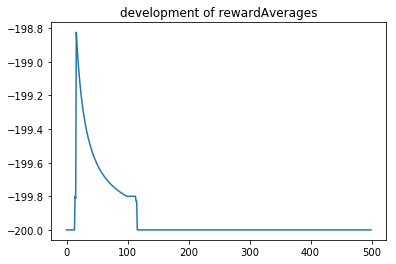

evaluation reset
cycle 1 starts:
Episode 499 done: steps: 134, r-average: -133.9, arrived 482(96.4%), maxReward: -133.0 in 40, best average: -133.7 in 135

cycle 1 done:
number episodes: 500
first time arrived in episode: 16
car arrived: 482 (96.4%)
best reward: -133.0 in episode 40
best average: -133.7 in episode 135
problem solved:False


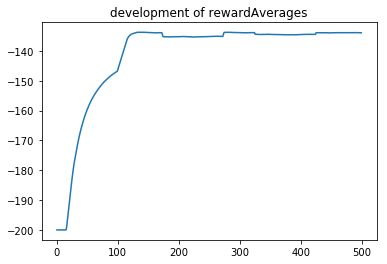

evaluation reset
cycle 2 starts:
Episode 499 done: steps: 200, r-average: -131.6, arrived 482(96.4%), maxReward: -122.0 in 330, best average: -130.1 in 347

cycle 2 done:
number episodes: 500
first time arrived in episode: 16
car arrived: 482 (96.4%)
best reward: -122.0 in episode 330
best average: -130.1 in episode 347
problem solved:False


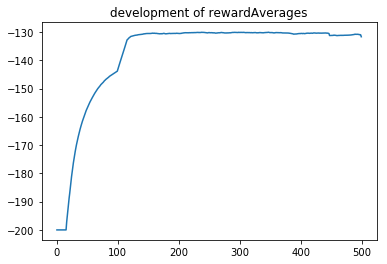

evaluation reset
cycle 3 starts:
Episode 499 done: steps: 200, r-average: -200.0, arrived 174(34.8%), maxReward: -84.0 in 205, best average: -137.3 in 192

cycle 3 done:
number episodes: 500
first time arrived in episode: 12
car arrived: 174 (34.8%)
best reward: -84.0 in episode 205
best average: -137.3 in episode 192
problem solved:False


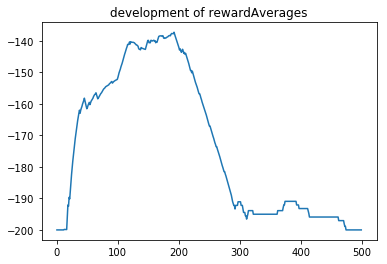

test finished after 4 runs
first arrival: mean: 14, std: 1.7
nb of arrival: mean: 285, std: 206.2
nb of arrival: mean: 57%, std: 41.2%
best reward  : mean: -130, std: 35.3
in episode   : mean: 148, std: 127.9
best average : mean: -150, std: 28.3
in episode   : mean: 172, std: 119.1
prblem solved: mean: 0, std: 0.0


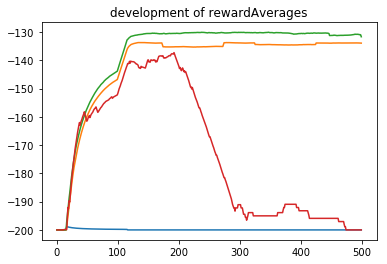

In [6]:
def policy(Q,epsilon):    
    if epsilon>0.0 and random.random() < epsilon:
        return env.action_space.sample()
    else: 
        return np.argmax(Q) 

def decayFunction(episode, pName):
    global nbEpisodes,policyP
    param=policyP[pName]
    if param['strategy']==0:
        return 1/((episode+1)**2)
    elif param['strategy'] ==1:
        return 1/(episode+1)
    elif param['strategy'] ==2:
        return (0.5)**episode
    elif param['strategy'] ==3:
        return 0.05
    elif param['strategy'] ==4:
        return max(param['start']-episode/param['interval'], param['base'])
    elif param['strategy'] ==5:
        return 0.5*(0.5**episode)+0.5
    elif param['strategy'] ==6:       #slow learner
        if episode < 20:
            return 0.5
        elif episode < 100:
            return 0.25
        else:
            return 0.1
    elif param['strategy'] ==7:              #fast learner
        if episode < 25:
            return 0.65
        elif episode < 35:
            return 0.6
        elif episode < 45:
            return 0.55
        else:
            return 0.5
    else:
        return param['static']
    
for cycle in range(nbCycles):
    #old evaluation
    lastDelta=-1000.0
    colorplot=np.empty([tileModel.nbTilings*tileModel.gridSize,tileModel.nbTilings*tileModel.gridSize],dtype=str)

    #prepare cycle
    tileModel.resetStates()
    evaluation.reset()
    evaluation.CycleStart(cycle)

    for episode in range(nbEpisodes):
    
        # decay - if administrated the parameters
        epsilon=decayFunction(episode, 'epsilon')
        gamma=decayFunction(episode, 'gamma')
        alpha=decayFunction(episode, 'alpha')
        
        # prepare the model
        state = env.reset()
        Q=tileModel.getQ(state)
        action = policy(Q,epsilon)

        #prepare evaluation
        rewardAccumulated =0
        deltaQAs=[0.0]
   
        for t in range(nbTimesteps):
            env.render()
            state_next, reward, done, info = env.step(action)
            rewardAccumulated+=reward
            ### print('\n--- step action:',action,'returns: reward:', reward, 'state_next:', state_next)
            if done:
                evaluation.EpiTrack(episode,t,rewardAccumulated)
                evaluation.EpiEval(episode,t)
                break

            #update Q(S,A)-Table according to:
            #Q(S,A) <- Q(S,A) + α (R + γ Q(S’, A’) – Q(S,A))
        
            #start with the information from the old state:
            #difference between Q(S,a) and actual reward
            #problem: reward belongs to state as whole (-1 for mountain car), Q[action] is the sum over several features
            
            #now we choose the next state/action pair:
            Q_next=tileModel.getQ(state_next)
            action_next=policy(Q_next,epsilon)
            action_QL=policy(Q_next,0.0)   

            if policySARSA:
                action_next_learning=action_next
            else:
                action_next_learning=action_QL

        
            # take into account the value of the next (Q(S',A') and update the tile model
            deltaQA=alpha*(reward + gamma * Q_next[action_next_learning] - Q[action])
            deltaQAs.append(deltaQA)
        
            ### print ('Q:', Q, 'action:', action, 'Q[action]:', Q[action])
            ### print ('Q_next:', Q_next, 'action_next:', action_next, 'Q_next[action_next]:', Q_next[action_next])
            ### print ('deltaQA:',deltaQA)
            tileModel.updateQ(state, action, deltaQA)
            ### print ('after update: Q:',tileModel.getQ(state))

        
        
            ###if lastDelta * deltaQA < 0:           #vorzeichenwechsel
            ###    print ('deltaQA in:alpha:', alpha,'reward:',reward,'gamma:',gamma,'action_next:', action_next,\
            ###           'Q_next[action_next]:',Q_next[action_next],'action:',action,'Q[action]:', Q[action],'deltaQA out:',deltaQA)
            ###lastDelta=deltaQA
        
            # prepare next round:
            state=state_next
            action=action_next
            Q=Q_next
               
        if printEpisodeResult:
            #evaluation of episode: development of deltaQA
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            ax1.plot(range(len(deltaQAs)),deltaQAs,'-')
            ax1.set_title("after episode:  {} - development of deltaQA".format(episode))
            plt.show()

            #evaluation of episode: states
            plotInput=tileModel.preparePlot()
            ### print ('states:', tileModel.states)
            ### print ('plotInput:', plotInput)
    
            fig = plt.figure()
            ax2 = fig.add_subplot(111, projection='3d')
    
            x=range(tileModel.nbTilings*tileModel.gridSize)
            y=range(tileModel.nbTilings*tileModel.gridSize)
            yUnscaled=y*tileModel.gridWidth[0]+tileModel.obsLow[0]
            xUnscaled=x*tileModel.gridWidth[1]+tileModel.obsLow[1]


            colors=['r','b','g']
            labels=['back','neutral','forward']
            for i in range(tileModel.nbActions):
                ax2.plot_wireframe(xUnscaled,yUnscaled,plotInput[x,y,i],color=colors[i],label=labels[i])

            ax2.set_xlabel('velocity')
            ax2.set_ylabel('position')
            ax2.set_zlabel('action')
            ax2.set_title("after episode:  {}".format(episode))
            ax2.legend()
            plt.show()

            #colorplot=np.empty([tileModel.nbTilings*tileModel.gridSize,tileModel.nbTilings*tileModel.gridSize],dtype=str)
            minVal=np.zeros(3)
            minCoo=np.empty([3,2])
            maxVal=np.zeros(3)
            maxCoo=np.empty([3,2])
            for ix in x:
                for iy in y:
                    if 0.0 <= np.sum(plotInput[ix,iy,:]) and np.sum(plotInput[ix,iy,:])<=0.003:
                        colorplot[ix,iy]='g'
                    elif colorplot[ix,iy]=='g':
                        colorplot[ix,iy]='blue'
                    else:
                        colorplot[ix,iy]='cyan'
                

            xUnscaled=np.linspace(tileModel.obsLow[0], tileModel.obsHigh[0], num=tileModel.nbTilings*tileModel.gridSize)
            yUnscaled=np.linspace(tileModel.obsLow[1], tileModel.obsHigh[1], num=tileModel.nbTilings*tileModel.gridSize)

            fig = plt.figure()
            ax3 = fig.add_subplot(111)
    
            for i in x:
                ax3.scatter([i]*len(x),y,c=colorplot[i,y],s=75, alpha=0.5)

            #ax3.set_xticklabels(xUnscaled)
            #ax3.set_yticklabels(yUnscaled)
            ax3.set_xlabel('velocity')
            ax3.set_ylabel('position')
            ax3.set_title("after episode:  {} visited".format(episode))
            plt.show()
        
    evaluation.CycleTrack()
    evaluation.CycleEval(cycle)
    
evaluation.TestEval(nbCycles)